# CSE688: Practical and Application of Machine Learning - Spring 2021
## Assignment 4a
### Authors

- B073040018 朱劭璿
- B072010029 陳居廷

#### (a) Please design an classifier only for digits 1, 3, 5, 7 in MNIST. Then use the trained classifier to detect anomaly data that is not in the set of 1, 3, 5, 7.

## Create Dataset

Number of training samples: 14312
Number of validation samples: 35000
Number of testing samples: 35000

Label: 3.0


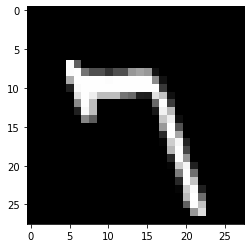

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from utils import anomaly_detect_split, AnomalyValidation

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
images = np.concatenate((train_images, test_images))
labels = np.concatenate((train_labels, test_labels))
# Normalize pixel values to be between 0 and 1
images = images / 255.0

(
    train_images, 
    train_labels, 
    val_images, 
    val_labels, 
    test_images, 
    test_labels
) = anomaly_detect_split(images, labels)

print(f'Number of training samples: {train_labels.shape[0]}')
print(f'Number of validation samples: {val_labels.shape[0]}')
print(f'Number of testing samples: {test_labels.shape[0]}')

ds_train = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).cache().shuffle(train_labels.shape[0]).batch(128).prefetch(tf.data.experimental.AUTOTUNE)
ds_val = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).cache().batch(128).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).cache().batch(128).prefetch(tf.data.experimental.AUTOTUNE)

print()
plt.imshow(train_images[0], cmap='gray')
print(f'Label: {train_labels[0]}')

## Model Design

In [2]:
classifier = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((28, 28, 1), input_shape=(28, 28)),
    tf.keras.layers.Conv2D(4, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
])
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 4)         40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         296       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 16)          0

## Training

In [3]:
LR = 1e-4
ATH = 0.8 # anomaly confidence threshold

In [4]:
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['sparse_categorical_accuracy']
)
history = classifier.fit(
    ds_train, 
    epochs=15,
    verbose=0,
    callbacks=[AnomalyValidation(ATH, ds_val)]
)
# AnomalyValidation callback: Perform anomaly detect on validation dataset
#                             Save the best weights and set the weight in training end

Epoch  1 Train  Loss:  2.233, Acc:  0.167	Anomaly detection accuracy:  0.59109
Epoch  2 Train  Loss:  1.704, Acc:  0.473	Anomaly detection accuracy:  0.59109
Epoch  3 Train  Loss:  1.009, Acc:  0.815	Anomaly detection accuracy:  0.59100
Epoch  4 Train  Loss:  0.635, Acc:  0.851	Anomaly detection accuracy:  0.68509
Epoch  5 Train  Loss:  0.430, Acc:  0.883	Anomaly detection accuracy:  0.74026
Epoch  6 Train  Loss:  0.326, Acc:  0.905	Anomaly detection accuracy:  0.71077
Epoch  7 Train  Loss:  0.267, Acc:  0.922	Anomaly detection accuracy:  0.65763
Epoch  8 Train  Loss:  0.228, Acc:  0.931	Anomaly detection accuracy:  0.65443
Epoch  9 Train  Loss:  0.200, Acc:  0.938	Anomaly detection accuracy:  0.64100
Epoch 10 Train  Loss:  0.178, Acc:  0.944	Anomaly detection accuracy:  0.65034
Epoch 11 Train  Loss:  0.161, Acc:  0.949	Anomaly detection accuracy:  0.63446
Epoch 12 Train  Loss:  0.147, Acc:  0.954	Anomaly detection accuracy:  0.63140
Epoch 13 Train  Loss:  0.135, Acc:  0.958	Anomaly de

## Inference

In [5]:
num_correct = 0
num_total = 0
for image, label in ds_test:
    confidence = tf.math.reduce_max(tf.nn.softmax(classifier(image)), 1).numpy()
    num_correct += ((confidence < ATH) == label.numpy()).sum()
    num_total += label.shape[0]
print(f'Anomaly detection accuracy: {num_correct/num_total: .5f}')

Anomaly detection accuracy:  0.73917
